In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import matplotlib
from itertools import product
from sklearn.neighbors import KernelDensity
from scipy.special import kl_div as kl_divergence
import matplotlib.pylab as pl
import pyrosetta as pr
pr.init("-mute core basic protocols")
matplotlib.rcParams["figure.figsize"] = (15,15)

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python35.linux 2019.45+release.fc8ab401178f6f099884fd5a39597b1a9cac8db2 2019-11-05T15:46:43] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [2]:
matplotlib.rcParams["figure.figsize"] = (10,10)

## [Visualisation] Data

In [3]:
dirname = ""
protein_names = [x.split(".")[0] for x in os.listdir(dirname + "contacts")]

ANGSTROM_BINS = np.arange(4,43,0.5)

class Protein:
    
    def __init__(self, dirname, name):
        self.name = name
        self.native = pr.io.pose_from_pdb(dirname + "pdb/" + name + ".pdb")
        self.sequence = self.native.sequence()
        self.contacts = pd.read_csv(dirname + "contacts/" + name + ".contacts", sep=" ", names=["i", "j", "_1", "_2", "p"])[["i", "j", "p"]]
        self.xl_photoAA = pd.read_csv(dirname + "photoAA_xl/" + name + "_FDR10", sep=" ", names=["i", "j"])
        self.xl_sulfo = pd.read_csv(dirname + "sulfo-SDA_xl/" + name + ".xl", sep=" ", names=["i", "j"])
        self.dist_info = np.load(dirname + 'distograms/' + name + '.npz')
        self.distogram = self.dist_info['distogram']
        self.ground_truth_dist = self._compute_ground_truth_dist()
        self.ground_truth_dist_clipped = self._compute_ground_truth_dist_clipped()
        print("Initialized " + self.name)
        
    def _compute_ground_truth_dist_clipped(self):
        return self.ground_truth_dist.clip(4,42.5)
        
        
    def _compute_ground_truth_dist(self):
        pose = self.native
        def xyz(pose,res):
        
            return pose.residue(res).xyz("N")
        residues = pose.total_residue()
        dist = np.zeros((residues,residues))
        for i, j in product(range(1,residues+1),range(1,residues+1)):
            dist[i-1,j-1] = (xyz(pose,i) - xyz(pose,j)).norm()
        
        return dist
    
        
    @staticmethod
    def estimate_dist_argmax(dist_3d):
        return np.argmax(dist_3d,axis=0) + 4 # count starts only at four angstrom
    
    @staticmethod
    def estimate_dist_weighted(dist_3d):
        a = np.sum(ANGSTROM_BINS[:,np.newaxis] * dist_3d.reshape(dist_3d.shape[0],-1), axis=0)
        return a.reshape(int(np.sqrt(a.shape[0])),-1)
        
    def __repr__(self):
        return self.name

p = Protein(dirname, protein_names[1])

Initialized 4ic1A00


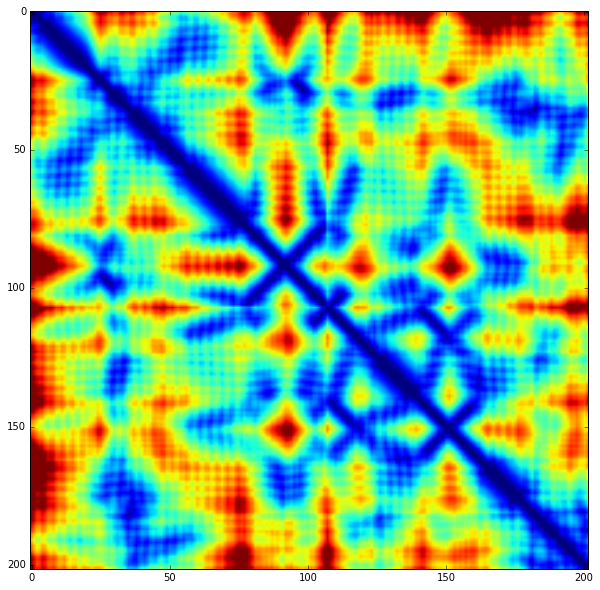

In [4]:
a = Protein.estimate_dist_weighted(p.distogram)
a = Protein.estimate_dist_argmax(p.distogram)
a = p.ground_truth_dist_clipped
plt.imshow(a)

In [5]:
def plot_contour(dist_2d, level_cnt=15):
    X,Y = np.meshgrid(range(dist_2d.shape[0]),range(dist_2d.shape[1]))
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    Z = dist_2d
    levels = np.linspace(0, Z.max(), level_cnt)
    plt.contour(X, Y, Z, levels=levels, cmap=plt.cm.cool)
    plt.colorbar()

In [14]:
def scatter_sulfo(p, ax):
    sulfo = p.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1 
    ax.scatter(sulfo[:,0], sulfo[:,1], color="blue", label="Sulfo")
    ax.scatter(sulfo[:,1], sulfo[:,0], color="blue")
    
def scatter_photo(p, ax):
    photoAA = p.xl_photoAA[["i", "j"]].values.astype(np.int32) - 1
    ax.scatter(photoAA[:,0], photoAA[:,1], color="red", label="photoAA")
    ax.scatter(photoAA[:,1], photoAA[:,0], color="red")

## [Method]:1 Convolve knowledge about existing contacts to nearby residues

In [15]:
def calc_distance_estimation_sulfo(p,bandwidth=3,kernel='gaussian'):
    sulfo = p.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1
    sulfo_all = np.vstack((sulfo,np.vstack((sulfo[:,1],sulfo[:,0])).T))
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(sulfo_all)
    residues = range(p.distogram.shape[1])
    X,Y = np.meshgrid(residues,residues)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    return np.exp(kde.score_samples(xy).reshape(len(residues),len(residues)))

def calc_distance_estimation_photo(p,bandwidth=3,kernel='gaussian'):
    photo = p.xl_photoAA[["i", "j"]].values.astype(np.int32) - 1
    photo_all = np.vstack((photo,np.vstack((photo[:,1],photo[:,0])).T))
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(photo_all)
    residues = range(p.distogram.shape[1])
    X,Y = np.meshgrid(residues,residues)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    return np.exp(kde.score_samples(xy).reshape(len(residues),len(residues)))

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6512: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6512: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


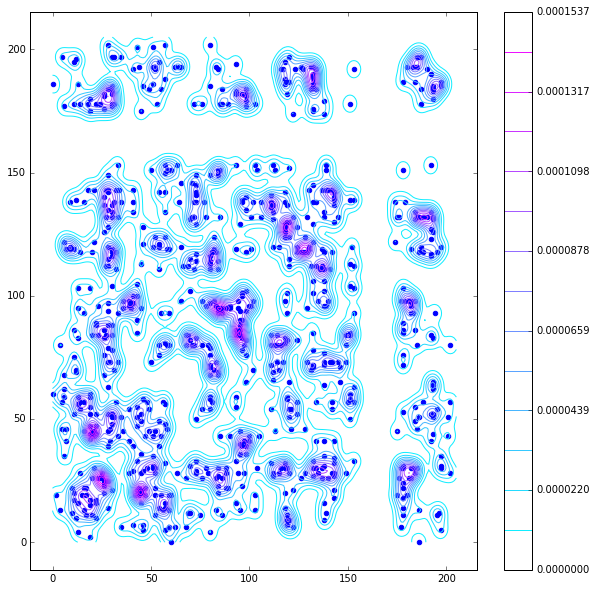

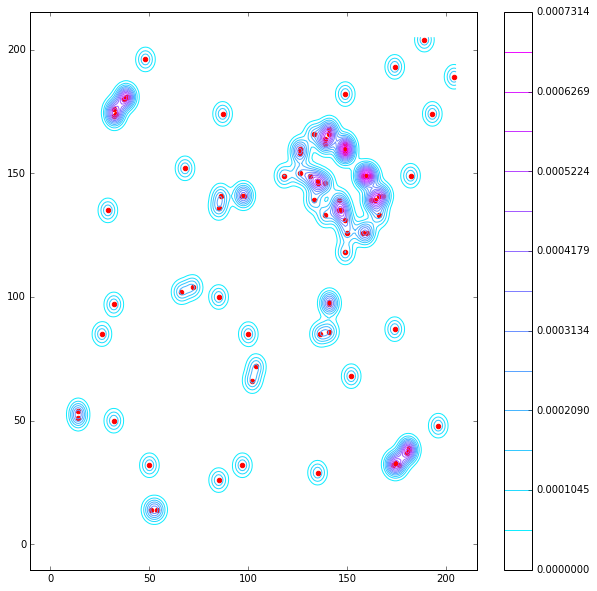

In [16]:
plot_contour(calc_distance_estimation_sulfo(p))
scatter_sulfo(p,plt.gca())
plt.show()

plot_contour(calc_distance_estimation_photo(p))
scatter_photo(p, plt.gca())

## [Method]:2 Combine predicted histogram with contact-derived 2d-<25Å distribution

##### Combine the 3d-crosslink distribution with the original prediction

In [66]:
additive_photo = np.load("dist_close.npy")
additive_sulfo = np.load("dist_medium.npy")
# magically convert 2d to 3d via the above function and some addition
def adapt_for_greater_than(dist, sulfo_Z, photo_Z, alpha_sulfo=1000, alpha_photo=1000):
    add = np.tile(additive_photo.reshape((-1, 1, 1)), (1, dist.shape[1], dist.shape[2]))
    weighted_add = photo_Z.reshape(-1, photo_Z.shape[0], photo_Z.shape[1]) * add * alpha_photo * 0
    dist_ = dist + weighted_add
    dist = dist_ / dist_.sum(axis=0)
    
    add = np.tile(additive_sulfo.reshape((-1, 1, 1)), (1, dist.shape[1], dist.shape[2]))
    weighted_add = sulfo_Z.reshape(-1, sulfo_Z.shape[0], sulfo_Z.shape[1]) * add * alpha_sulfo
    dist_ = dist + weighted_add
    dist_ /= dist_.sum(axis=0)
    
    return dist_

In [67]:
# putting it all together
new_distribution = adapt_for_greater_than(p.distogram, calc_distance_estimation_sulfo(p), calc_distance_estimation_photo(p))

##### Visualisation of the impact of this process

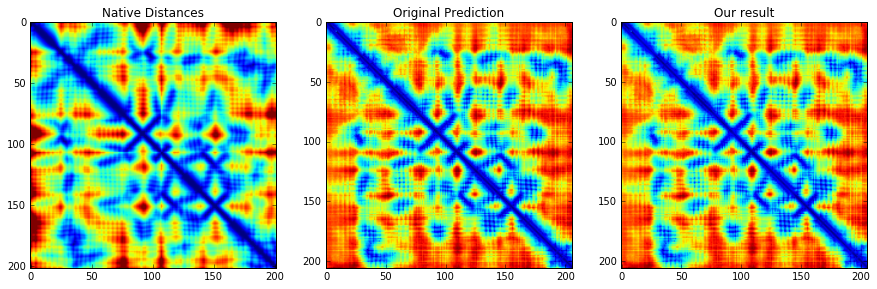

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))

# native
ax1.imshow(p.ground_truth_dist_clipped)
ax1.set_title('Native Distances')

# original distogram
ax2.imshow(Protein.estimate_dist_weighted(p.distogram))
scatter_sulfo(p,ax2)
ax2.set_title('Original Prediction')

# new distogram 
ax3.imshow(Protein.estimate_dist_weighted(new_distribution))
ax3.set_title('Our result');

## [Evaluation]:1 Accuracy of distogram

In [ ]:
# todo: 
# - measure how much change we actually introduced in the 3d distribution (KL-div)
# - compare two 2D distributions (mse? KL-div)
def jensen(a,b):
    return (kl_divergence(a,b) + kl_divergence(b,a))/2

a = np.sum(jensen(new_distribution,p.distogram), axis=0)
plt.imshow(a)
plt.show()
# - compare two 2D distributions (mse? KL-div)
a = np.sum(kl_divergence(p.distogram, p.distogram), axis=0)
plt.imshow(a)
plt.show()

## [Evaluation]:2 Improvement in Minimisation 

In [ ]:
import sys, os

def save_to_rosetta_format_cmd(p, distogram_file, name):
    # for converting to rosetta
    python = sys.executable
    snippet = 'code/distograms_to_rosetta.py'
    params = ' '.join(['--prediction', distogram_file, 
    '--fasta', 'fasta/'+ p.name +  '.fasta', 
    '--cst_folder', 'experimental_cst/' + name.replace('.','_'),
    '--cst_file', 'experimental_cst/' + name ])
    return ' '.join([python, snippet, params])
    

def minimize_cmd(p,dist_file_rosetta, outname):
    python = sys.executable
    snippet = "minimize.py"
    params = ' '.join(['--fasta', 'fasta/' + p.name + '.fasta', 
    '--prediction', 'distograms/' + p.name + '.npz',
    '--mapping' , 'mapping/' + p.name,
    '--native', 'pdb/' + p.name + '.pdb',
    '--output', outname,
    '--constraint', 'experimental_cst/' + dist_file_rosetta])
    return ' '.join([python, snippet, params])


def save_all(p,new_dist,name):
    np.savez(name, 
             distogram=new_dist, 
             ss=p.dist_info['ss'], 
             phi=p.dist_info['phi'], 
             phi_kappa=p.dist_info['phi_kappa'] , 
             psi=p.dist_info['psi'] , 
             psi_kappa=p.dist_info['ss'])

In [ ]:
# the new distogram
new_distribution = new_distribution # (example)

# when we want to use our new distogram in the minimisation, 
# we need to update the numpy and rosetta-constraint files
dist_file_rosetta = 'testrun.cst'
dist_file_numpy = 'testrun.npz'

# also give a name to the output file of our result
outname ='test.pdb'

# this will take about 15-20mins
save_all(p,new_distribution,dist_file_numpy)
cmd1 = save_to_rosetta_format_cmd(p,dist_file_numpy, dist_file_rosetta)
print(cmd1)
print()
cmd2 = minimize_cmd(p,dist_file_rosetta, outname)
print(cmd2)

# todo: measures
# - closeness to native
# - energy state
# - time to convergence

In [ ]:
 a=

In [ ]:
# execute 
os.system(cmd1)
os.system(cmd2)

In [ ]:
a = 1
a.__str__()